IMPORT STATEMENTS...

In [22]:
import os
import json
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_curve,roc_auc_score,classification_report)

import matplotlib.pyplot as plt
import shap

import joblib 

After the Preprocessing the data looks as shown in the csv file called 'preprocessing.csv'...

There are 166067 rows indexed by time

There are 9 columns: Time, Glucose, Carbohydrates, Rapid Insulin, Long Insulin, bpm, distanc and  calories.


In [23]:
preprocessed = "C:/Users/emmxc/OneDrive/Escritorio/thesis/FinalProjectThesis/MachineLearning/preprocessing.csv"
df = pd.read_csv(preprocessed, sep="\t")


Descriptive statistics for this preprocessed dataset...

In [24]:
# Define the columns
columns_to_plot = ['Glucose','Carbohydrates', 'Rapid Insulin', 'Long Insulin', 'BPM', 'Calories', 'Distance']


print("\n--- Descriptive Statistics harmonized Summary ---")

for column in columns_to_plot:
    print(f"\n[{column}]")

    # Basic stats
    col_data = df[column].dropna()
    total = len(df)
    non_missing = len(col_data)
    missing = total - non_missing
    missing_pct = (missing / total) * 100

    print(f" - Total records: {total}")
    print(f" - Non-missing values: {non_missing}")
    print(f" - Missing values: {missing} ({missing_pct:.2f}%)")
    print(f" - Min: {col_data.min():.2f}" if not col_data.empty else " - Min: N/A")
    print(f" - Max: {col_data.max():.2f}" if not col_data.empty else " - Max: N/A")
    print(f" - Mean: {col_data.mean():.2f}" if not col_data.empty else " - Mean: N/A")
    print(f" - Std Dev: {col_data.std():.2f}" if not col_data.empty else " - Std Dev: N/A")

    # Imbalance / zero-value detection
    zeros = (col_data == 0).sum()
    if zeros > 0:
        zeros_pct = (zeros / non_missing) * 100
        print(f" - Zero values: {zeros} ({zeros_pct:.2f}%)")
    else:
        print(" - No zero values")

    # Spike detection (optional for e.g., Glucose or BPM)
    if column in ['Glucose', 'BPM']:
        spikes = col_data.diff().abs() > col_data.std()
        spike_count = spikes.sum()
        print(f" - Sudden changes (spikes): {spike_count}")


HYPER_THRESHOLD = 6.9  
HYPO_THRESHOLD = 3.9    

glucose_data = df['Glucose'].dropna()
total_points = len(glucose_data)

n_hyper = (glucose_data > HYPER_THRESHOLD).sum()
n_hypo = (glucose_data < HYPO_THRESHOLD).sum()
n_normo = total_points - n_hyper - n_hypo


pct_hyper = (n_hyper / total_points) * 100
pct_hypo = (n_hypo / total_points) * 100
pct_normo = (n_normo / total_points) * 100


print("\n--- Glucose Episode Breakdown ---")
print(f"Total glucose readings: {total_points}")
print(f"Hyperglycemic episodes: {n_hyper} ({pct_hyper:.2f}%)")
print(f"Hypoglycemic episodes: {n_hypo} ({pct_hypo:.2f}%)")
print(f"Normoglycemic readings: {n_normo} ({pct_normo:.2f}%)")


--- Descriptive Statistics harmonized Summary ---

[Glucose]
 - Total records: 2688
 - Non-missing values: 2613
 - Missing values: 75 (2.79%)
 - Min: 2.90
 - Max: 18.90
 - Mean: 8.29
 - Std Dev: 3.11
 - No zero values
 - Sudden changes (spikes): 12

[Carbohydrates]
 - Total records: 2688
 - Non-missing values: 2688
 - Missing values: 0 (0.00%)
 - Min: 0.00
 - Max: 69.00
 - Mean: 1.87
 - Std Dev: 6.64
 - Zero values: 2380 (88.54%)

[Rapid Insulin]
 - Total records: 2688
 - Non-missing values: 2688
 - Missing values: 0 (0.00%)
 - Min: 0.00
 - Max: 10.00
 - Mean: 0.25
 - Std Dev: 1.24
 - Zero values: 2547 (94.75%)

[Long Insulin]
 - Total records: 2688
 - Non-missing values: 2688
 - Missing values: 0 (0.00%)
 - Min: 0.00
 - Max: 15.00
 - Mean: 0.14
 - Std Dev: 1.37
 - Zero values: 2660 (98.96%)

[BPM]
 - Total records: 2688
 - Non-missing values: 2673
 - Missing values: 15 (0.56%)
 - Min: 47.80
 - Max: 121.60
 - Mean: 70.60
 - Std Dev: 12.87
 - No zero values
 - Sudden changes (spikes): 

Because of the absorption nature of Insulin and Carbohydrates we need to implement as a comparimental model two mathematical model differential equations to transformt he insulin injection and cabrohydrates intake into CABROHYDRATES ON BOARD and INSULIN ON BOARD which are the carbs and insulin inside the bloodstream at a given point in time...

Firstly I did a version of the mathematical models to be tested which made up data (two injections and one meal) to understand how the absoprtion is modeled!

In [25]:

# === FAKE DATA GENERATION ===
# 25 time points (6 hours, 15-min intervals)
time_steps = 40  # ~10 hours at 15-minute intervals
start_time = datetime.now()
time_range = [start_time + timedelta(minutes=15 * i) for i in range(time_steps)]

df_kinetics = pd.DataFrame({
    'Time': time_range,
    'Carbohydrates': [0]*time_steps,
    'Rapid Insulin': [0]*time_steps,
    'Long Insulin': [0]*time_steps
})

df_kinetics.at[0, 'Long Insulin'] = 10       # Inject long insulin at start
df_kinetics.at[24, 'Rapid Insulin'] = 6      # Inject rapid insulin after 6 hours

# Simulate 1 meal (40g), 1 rapid insulin (6U), and 1 long insulin (10U) at t=0
df_kinetics.at[0, 'Carbohydrates'] = 40

def carbs_to_cob(df, carb_col='Carbohydrates', dt=15, t_max=40):
    Q1 = np.zeros(len(df))
    Q2 = np.zeros(len(df))
    
    for i in range(1, len(df)):
        # Take carbs from previous step — they happen *before* absorption starts
        c = df.iloc[i - 1][carb_col]
        
        dQ1 = (-Q1[i - 1] / t_max) * dt + 0.8 * c

        dQ2 = (Q1[i - 1] / t_max - Q2[i - 1] / t_max) * dt



        Q1[i] = Q1[i - 1] + dQ1
        Q2[i] = Q2[i - 1] + dQ2

    df['COB'] = Q2
    return df


df_kinetics = carbs_to_cob(df_kinetics)


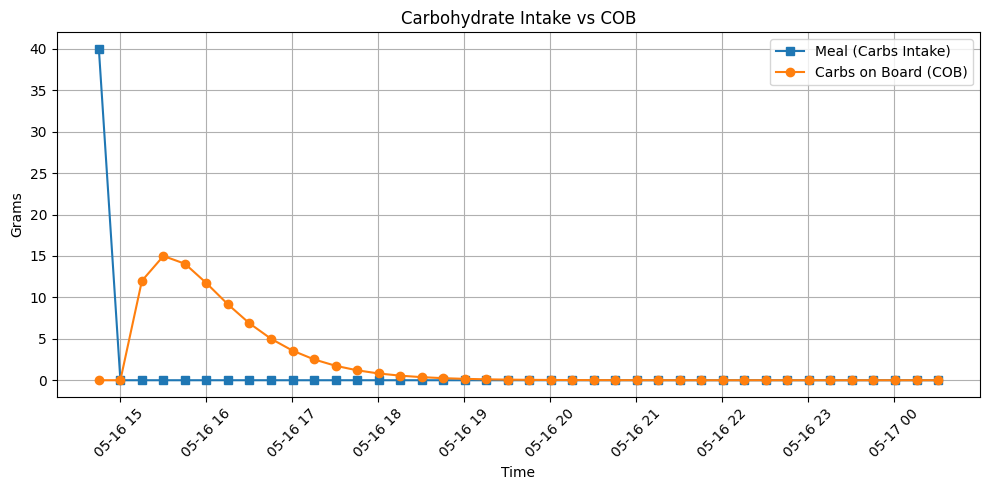

In [26]:
# === PLOT 1: Meal vs COB ===
plt.figure(figsize=(10, 5))
plt.plot(df_kinetics['Time'], df_kinetics['Carbohydrates'], label='Meal (Carbs Intake)', marker='s')
plt.plot(df_kinetics['Time'], df_kinetics['COB'], label='Carbs on Board (COB)', marker='o')
plt.xlabel('Time')
plt.ylabel('Grams')
plt.title('Carbohydrate Intake vs COB')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



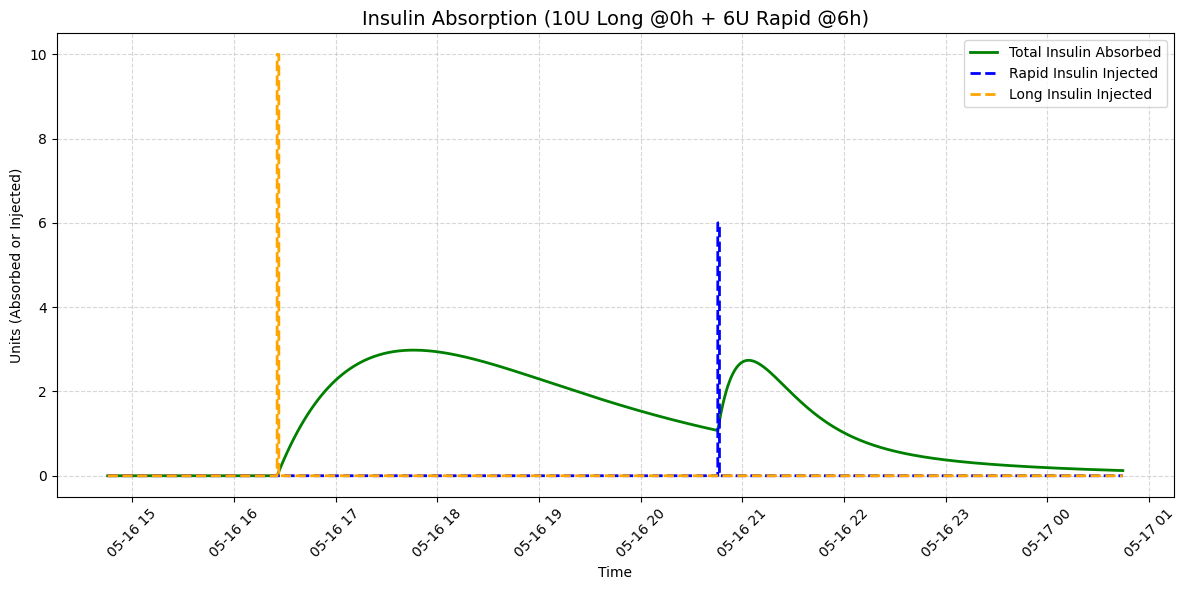

In [27]:

# Time setup
dt = 1  # 1-minute resolution
total_minutes = 10 * 60
steps = total_minutes // dt
time_range = [datetime.now() + timedelta(minutes=i*dt) for i in range(steps)]

# Injection profile (hardcoded)
rapid_injection = np.zeros(steps)
long_injection = np.zeros(steps)
rapid_injection[360] = 6    # inject 6U rapid at 6h
long_injection[100] = 10      # inject 10U long at t=0

# 2-compartment absorption model
def insulin_absorption_model(injection_array, ka1, ka2):
    Q1 = np.zeros(steps)
    Q2 = np.zeros(steps)
    for i in range(1, steps):
        inj = injection_array[i]
        dQ1 = (-ka1 * Q1[i-1] + inj) * dt
        dQ2 = (ka1 * Q1[i-1] - ka2 * Q2[i-1]) * dt
        Q1[i] = Q1[i-1] + dQ1
        Q2[i] = Q2[i-1] + dQ2
    return Q2

# Parameters
ka1_rapid, ka2_rapid = 0.04, 0.06
ka1_long, ka2_long = 0.01, 0.015

# Simulate absorption
rapid_abs = insulin_absorption_model(rapid_injection, ka1_rapid, ka2_rapid)
long_abs = insulin_absorption_model(long_injection, ka1_long, ka2_long)
total_abs = rapid_abs + long_abs

# Plot total absorption + injections
plt.figure(figsize=(12, 6))
plt.plot(time_range, total_abs, label='Total Insulin Absorbed', color='green', linewidth=2)
plt.step(time_range, rapid_injection, label='Rapid Insulin Injected', where='post', linestyle='--', color='blue', linewidth=2)
plt.step(time_range, long_injection, label='Long Insulin Injected', where='post', linestyle='--', color='orange', linewidth=2)

plt.title("Insulin Absorption (10U Long @0h + 6U Rapid @6h)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Units (Absorbed or Injected)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Since the mathematical models seem correct as reported in the literature, we can apply thes emethods to our dataset to obtain the new columns of insulin on baord (IOB) and carbs on board (COB)

In [28]:
df_kinetics = df.copy()

steps = len(df_kinetics)
dt = 1 


rapid_injection = df_kinetics['Rapid Insulin'].fillna(0).values
long_injection = df_kinetics['Long Insulin'].fillna(0).values


def insulin_absorption_model(rapid_array, long_array, ka1_r=0.04, ka2_r=0.06, ka1_l=0.01, ka2_l=0.015):
    Q1_r = np.zeros(steps)
    Q2_r = np.zeros(steps)
    Q1_l = np.zeros(steps)
    Q2_l = np.zeros(steps)

    for i in range(1, steps):
        inj_r = rapid_array[i]
        inj_l = long_array[i]

        dQ1_r = (-ka1_r * Q1_r[i-1] + inj_r) * dt
        dQ2_r = (ka1_r * Q1_r[i-1] - ka2_r * Q2_r[i-1]) * dt

        dQ1_l = (-ka1_l * Q1_l[i-1] + inj_l) * dt
        dQ2_l = (ka1_l * Q1_l[i-1] - ka2_l * Q2_l[i-1]) * dt

        Q1_r[i] = Q1_r[i-1] + dQ1_r
        Q2_r[i] = Q2_r[i-1] + dQ2_r

        Q1_l[i] = Q1_l[i-1] + dQ1_l
        Q2_l[i] = Q2_l[i-1] + dQ2_l

    return Q2_r + Q2_l  # Insulin on board 


df_kinetics['Insulin on board'] = insulin_absorption_model(rapid_injection, long_injection)
df_kinetics['Insulin absorption'] = insulin_absorption_model(rapid_injection, long_injection)


In [29]:
def carbs_to_cob(df, carb_col='Carbohydrates', dt=15, t_max=40):
    Q1 = np.zeros(len(df))
    Q2 = np.zeros(len(df))
    
    for i in range(1, len(df)):
    
        c = df.iloc[i - 1][carb_col]
        
        dQ1 = (-Q1[i - 1] / t_max) * dt + 0.8 * c

        dQ2 = (Q1[i - 1] / t_max - Q2[i - 1] / t_max) * dt



        Q1[i] = Q1[i - 1] + dQ1
        Q2[i] = Q2[i - 1] + dQ2

    df['COB'] = Q2
    return df


df_kinetics = carbs_to_cob(df_kinetics)

For educational purposes we will also incluse the columns of Minutes since last Carbs, Minutes since last Insulin and Last insulin Type, so that we can dispplay those data later on the interface

In [30]:
df_kinetics['Minutes since last Carbs'] = pd.NA
df_kinetics['Minutes since last Insulin'] = pd.NA
df_kinetics['Last Insulin Type'] = pd.NA

df_kinetics['Time'] = pd.to_datetime(df_kinetics['Time'])

last_carbs_index = None
last_rapid_index = None
last_long_index = None


for i in range(len(df_kinetics)):
    time_i = df_kinetics.at[i, 'Time']

    # Carbs
    if df_kinetics.at[i, 'Carbohydrates'] > 0:
        last_carbs_index = i
        df_kinetics.at[i, 'Minutes since last Carbs'] = 0
    elif last_carbs_index is not None:
        time_last_carbs = df_kinetics.at[last_carbs_index, 'Time']
        delta = (time_i - time_last_carbs).total_seconds() / 60
        df_kinetics.at[i, 'Minutes since last Carbs'] = int(delta)

    # Insulin
    insulin_type = None
    if df_kinetics.at[i, 'Rapid Insulin'] > 0:
        last_rapid_index = i
        insulin_type = "Rapid"
        df_kinetics.at[i, 'Minutes since last Insulin'] = 0
        df_kinetics.at[i, 'Last Insulin Type'] = "Rapid"
    elif df_kinetics.at[i, 'Long Insulin'] > 0:
        last_long_index = i
        insulin_type = "Long"
        df_kinetics.at[i, 'Minutes since last Insulin'] = 0
        df_kinetics.at[i, 'Last Insulin Type'] = "Long"
    else:
        # Determine most recent insulin injection type
        if last_rapid_index is not None and last_long_index is not None:
            time_rapid = df_kinetics.at[last_rapid_index, 'Time']
            time_long = df_kinetics.at[last_long_index, 'Time']
            if time_rapid > time_long:
                delta = (time_i - time_rapid).total_seconds() / 60
                df_kinetics.at[i, 'Minutes since last Insulin'] = int(delta)
                df_kinetics.at[i, 'Last Insulin Type'] = "Rapid"
            else:
                delta = (time_i - time_long).total_seconds() / 60
                df_kinetics.at[i, 'Minutes since last Insulin'] = int(delta)
                df_kinetics.at[i, 'Last Insulin Type'] = "Long"
        elif last_rapid_index is not None:
            delta = (time_i - df_kinetics.at[last_rapid_index, 'Time']).total_seconds() / 60
            df_kinetics.at[i, 'Minutes since last Insulin'] = int(delta)
            df_kinetics.at[i, 'Last Insulin Type'] = "Rapid"
        elif last_long_index is not None:
            delta = (time_i - df_kinetics.at[last_long_index, 'Time']).total_seconds() / 60
            df_kinetics.at[i, 'Minutes since last Insulin'] = int(delta)
            df_kinetics.at[i, 'Last Insulin Type'] = "Long"


df_kinetics.to_csv('kinetics.csv', sep='\t', index=False)